In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns

In [58]:
'''Read in data'''
calibyear = 2017

#Uncalibrated data
SPRUCEuncalib = xr.open_dataset('ELM-SPRUCE/initRUN/TEST_US-SPR_ICB20TRCNPRDCTCBC/run/TEST_US-SPR_ICB20TRCNPRDCTCBC.clm2.h0.' + str(calibyear) + '-01-01-00000.nc')
CLMuncalib = xr.open_dataset('CLM5/initRUNS/mbp_tuning_spinup_grass_CONTROL_v0/mbp_tuning_spinup_grass_CONTROL_v0.clm2.h1.' + str(calibyear) + '-01-01-00000.nc')
HILLSLOPEuncalib = xr.open_dataset('CLM-hillslope/3col-lagg-initial/run/test-hillslope-mct-srof-lagg.clm2.h1.2017-12.nc')

In [19]:
'''Load calibration WTE data'''
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in the metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

# Pull out 2017 year
wte = dt1[dt1.DATE.dt.year == 2017]
wte = wte[wte.PEATLAND == 'S2'].reset_index(drop = True)
wte['WTD'] = -(422.0 - wte.WTE)

In [25]:
'''Load calibration Streamflow data'''
infile2  ="https://pasta.lternet.edu/package/data/eml/edi/573/1/2aca4b900546e80ed7dd409ff1ad9787".strip() 
infile2  = infile2.replace("https://","http://")
                 
dt2 =pd.read_csv(infile2, skiprows = 1, sep = ",",
                 names = ["Peatland", "DateTime", "Stage_ft", "Q_cfs", "q_mmh", "q_interval"],
                 parse_dates=['DateTime'],
                 na_values={'Q_cfs':['NA',], 'q_mmh':['NA',], 'q_interval':['NA',],})

dt2.Peatland=dt2.Peatland.astype('category') 
dt2=dt2.assign(DateTime_datetime=pd.to_datetime(dt2.DateTime,errors='coerce')) 
dt2.Q_cfs=pd.to_numeric(dt2.Q_cfs,errors='coerce') 
dt2.q_mmh=pd.to_numeric(dt2.q_mmh,errors='coerce') 
dt2.q_interval=pd.to_numeric(dt2.q_interval,errors='coerce') 

# Pull out 2017 year
stream = dt2[dt2.DateTime.dt.year == 2017]
stream = stream[stream.Peatland == 'S2'].reset_index(drop = True)
stream['q_mms'] = stream.q_mmh/(60*60)

In [83]:
HILLSLOPEuncalib

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                         column: 3, time: 1, hist_interval: 2, lndgrid: 1,
                         gridcell: 1, landunit: 1, pft: 3)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) object 2018-01-01 00:00:00
Dimensions without coordinates: column, hist_interval, lndgrid, gridcell,
                                landunit, pft
Data variables: (12/80)
    hslp_distance       (column) float64 ...
    hslp_width          (column) float64 ...
    hslp_area           (column) float64 ...
    hslp_elev           (column) float64 ...
    hslp_slope          (column) float64 ...
    hslp_aspect         (column) float64 ...
    ...                  ...
    SNOW                (time, column) float32 ...
    SOILICE             (time, levsoi, column) float32 ...
    TSA                 (time, pft) float32 ...
    TSOI                (time, levgrnd, column) float32 ...
    ZWT                 (time, column) float32 ...
    ZWT_PERCH           (time, column) float32 ...
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 08/22/23 11:57:34
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./test-hillslope-mct-srof-lagg.clm2...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [60]:
SPRUCEuncalib

<xarray.Dataset>
Dimensions:                   (levgrnd: 15, levlak: 10, levdcmp: 15, time: 365,
                               hist_interval: 2, lndgrid: 2, ltype: 9,
                               natpft: 17)
Coordinates:
  * levgrnd                   (levgrnd) float32 0.007101 0.02792 ... 21.33 35.18
  * levlak                    (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                   (levdcmp) float32 0.007101 0.02792 ... 21.33 35.18
  * time                      (time) object 2017-01-01 00:00:00 ... 2017-12-3...
Dimensions without coordinates: hist_interval, lndgrid, ltype, natpft
Data variables: (12/541)
    mcdate                    (time) int32 ...
    mcsec                     (time) int32 ...
    mdcur                     (time) int32 ...
    mscur                     (time) int32 ...
    nstep                     (time) int32 ...
    time_bounds               (time, hist_interval) object ...
    ...                        ...
    cn_scalar                 (time, lndgrid) float32 ...
    cp_scalar                 (time, lndgrid) float32 ...
    leaf_npimbalance          (time, lndgrid) float32 ...
    nlim_m                    (time, lndgrid) float32 ...
    o2_decomp_depth_unsat     (time, levgrnd, lndgrid) float32 ...
    plim_m                    (time, lndgrid) float32 ...
Attributes: (12/25)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/07/23 17:10:36
    source:                                    Community Land Model CLM4.0
    hostname:                                  ubuntu
    ...                                        ...
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    Time_constant_3Dvars_filename:             ./TEST_US-SPR_ICB20TRCNPRDCTCB...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

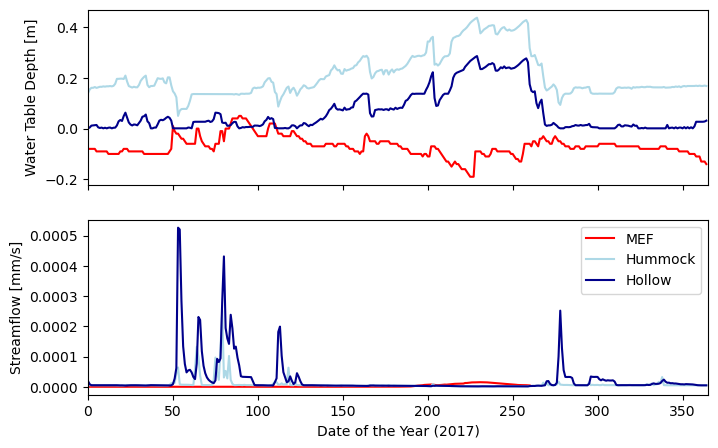

In [74]:
'''Plot Model Results'''
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 5), 
                              sharex = True)

#Plot Marcell data
ax1.plot(wte.WTD, color = 'red', label ='MEF')
ax2.plot(stream.q_mms, color = 'red', label ='MEF')

#Plot model data
ax1.plot(SPRUCEuncalib.ZWT.isel(lndgrid = [0]), color = 'lightblue')
ax1.plot(SPRUCEuncalib.ZWT.isel(lndgrid = [1]), color = 'darkblue')

ax2.plot(SPRUCEuncalib.QRUNOFF.isel(lndgrid = [0]), color = 'lightblue', label = "Hummock")
ax2.plot(SPRUCEuncalib.QRUNOFF.isel(lndgrid = [1]), color = 'darkblue', label = "Hollow")

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth [m]')
ax2.set_ylabel('Streamflow [mm/s]')
plt.xlim(0, 365)
plt.legend()

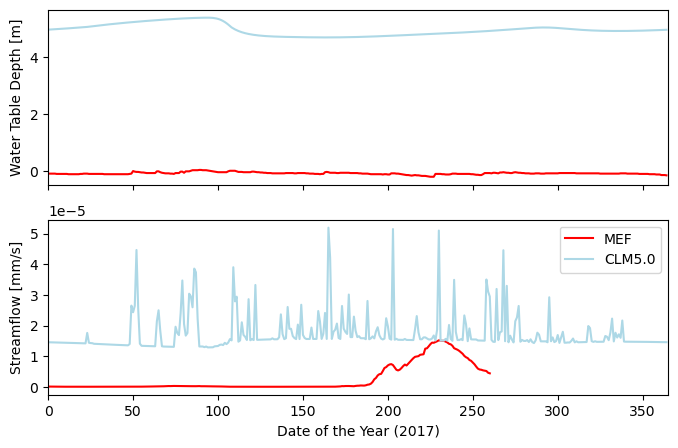

In [77]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 5), 
                              sharex = True)

#Plot Marcell data
ax1.plot(wte.WTD, color = 'red', label ='MEF')
ax2.plot(stream.q_mms, color = 'red', label ='MEF')

#Plot model data
ax1.plot(CLMuncalib.ZWT, color = 'lightblue')

ax2.plot(CLMuncalib.QRUNOFF, color = 'lightblue', label = 'CLM5.0')

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth [m]')
ax2.set_ylabel('Streamflow [mm/s]')
plt.xlim(0, 365)
plt.legend()

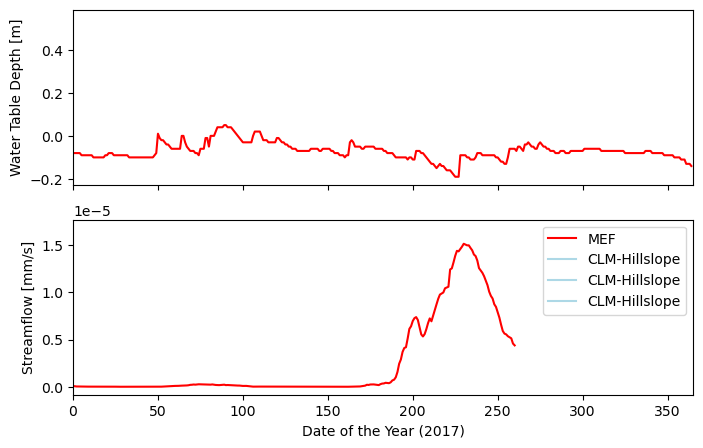

In [89]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (8, 5), 
                              sharex = True)

#Plot Marcell data
ax1.plot(wte.WTD, color = 'red', label ='MEF')
ax2.plot(stream.q_mms, color = 'red', label ='MEF')

#Plot model data
ax1.plot(HILLSLOPEuncalib.ZWT, color = 'lightblue')

ax2.plot(HILLSLOPEuncalib.QRUNOFF, color = 'lightblue', label = "CLM-Hillslope")

#Plot spcifics
ax2.set_xlabel('Date of the Year (2017)')
ax1.set_ylabel('Water Table Depth [m]')
ax2.set_ylabel('Streamflow [mm/s]')
plt.xlim(0, 365)
plt.legend()